# Recurrent Neural Net (RNN) w/Embedding

Compared to the previous model, there are a couple of optimisations we can make.

1. We can use Embeddings on categorical variables instead of Binary variables, with the hope the Embeddings manage to capture general aspects of our data.
2. We can use a Multi-Head structure. In the previous example we included customer specific attributes such as *age* and *gender* in the series. But they are constant, they do not change with each payment. Repeating them might be suboptimal, we could set-up a Multi-Head input and split out the *Customer* specific from the *Transaction* specific attributes.

---
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

In [1]:
import torch
import numpy as np
import datetime as dt
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.

For this example the intermediary features are split up into a __customer_learning__ (with age and gender) and a __transction_learning__ (with the category, merchant and amount index). The transaction_learning also includes the Customer and Datetime features because we need those to build a stacked series.

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        step,
        customer,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

# Function to calculate the date and time from the step
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

intermediate_features = ft.TensorDefinition(
    'intermediate', 
    [
        customer,
        step,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)

cust_learn_features = ft.TensorDefinition(
    'customer_learning', 
    [
        age_i,
        gender_i,
    ])

trx_learn_features = ft.TensorDefinition(
    'transaction_learning', 
    [
        customer,
        date_time,
        merchant_i,
        category_i,
        amount_binned,
        fraud_label
    ])


with en.EnginePandasNumpy() as e:
    df = e.from_csv(base_features, file, inference=False)
    df = e.from_df(intermediate_features, df, inference=False)
    cust_df = e.from_df(cust_learn_features, df, inference=False)
    trx_df  = e.from_df(trx_learn_features, df, inference=False)

2020-12-18 13:02:56.461 d373c7.engines.common          INFO     Start Engine...
2020-12-18 13:02:56.461 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2020-12-18 13:02:56.461 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-12-18 13:02:56.462 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2020-12-18 13:02:56.673 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2020-12-18 13:02:56.686 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 8)
2020-12-18 13:02:56.687 d373c7.engines.panda_numpy     INFO     Building Panda for : <intermediate> from DataFrame. Inference mode <False>
2020-12-18 13:02:56.698 d373c7.engines.panda_numpy     INFO     Done creating intermediate. Shape=(594643, 8)
2020-12-18 13:02:56.699 d373c7.engines.panda_numpy     INFO     Building Panda for : <customer_learning> from DataFrame. Infere

In [5]:
# Display Customer feature DataFrame
cust_df

,age_index,gender_index
0,1,1
1,2,1
2,1,2
3,3,1
4,4,1
...,...,...
594638,3,2
594639,1,2
594640,2,2
594641,4,1


In [6]:
# Display Transaction feature DataFrame
trx_df

,customer,date,merchant_index,category_index,amount_bin,fraud_label
0,C1093826151,2020-01-01,1,1,1,0
1,C352968107,2020-01-01,1,1,1,0
2,C2054744914,2020-01-01,2,1,1,0
3,C1760612790,2020-01-01,1,1,1,0
4,C757503768,2020-01-01,1,1,1,0
...,...,...,...,...,...,...
594638,C1753498738,2020-06-28,2,1,1,0
594639,C650108285,2020-06-28,2,1,1,0
594640,C123623130,2020-06-28,15,11,1,0
594641,C1499363341,2020-06-28,2,1,1,0


## Convert to Numpy and Build series

Build the series on the transaction learning features. Use a regular to_numpy for the Customer referential data. 

After this step will will have a *Rank-2* tensor for the __Customer__ data (with the batch being the first dimension and the age and gender indexes being the second dimension), and a *Rank-3* tensor (series) for the __Transactional__ data (having the batch as first dimension, the time as second dimensions and the category, merchant and amount indexes as thrid dimension).

In this case the series output has the labels in it, we could have also added it to the Customer data, that would make no difference.

In [7]:
multi_head_td = ft.TensorDefinitionMulti([cust_learn_features, trx_learn_features])
with en.EnginePandasNumpy(num_threads=8) as e:
    cust_list = e.to_numpy_list(cust_learn_features, cust_df)
    series_list = e.to_series_stacked(trx_df, trx_learn_features, key_field=customer, time_field=date_time, length=5)

print('Customer data Shapes')
print(cust_list.shapes)
print(cust_list.dtype_names)
print('Series Shapes')
print(series_list.shapes)
print(series_list.dtype_names)

data_list = en.NumpyList(cust_list.lists + series_list.lists)
print('Numpy Shapes')
print(data_list.shapes)

2020-12-03 14:29:45.325 d373c7.engines.common          INFO     Start Engine...
2020-12-03 14:29:45.325 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2020-12-03 14:29:45.325 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-12-03 14:29:45.325 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2020-12-03 14:29:45.326 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Categorical
2020-12-03 14:29:45.327 d373c7.engines.panda_numpy     INFO     Start creating stacked series for Tensor Definition <transaction_learning> using 8 process(es)
2020-12-03 14:29:50.384 d373c7.engines.panda_numpy     INFO     Returning series of types ['int16', 'int8'].
2020-12-03 14:29:50.385 d373c7.engines.panda_numpy     INFO     Done creating transaction_learning. Shapes=[(594643, 5, 3), (594643, 1)]


Customer data Shapes
[(594643, 2)]
['int8']
Series Shapes
[(594643, 5, 3), (594643, 1)]
['int16', 'int8']
Numpy Shapes
[(594643, 2), (594643, 5, 3), (594643, 1)]


## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

For time-series we'll perform an additional action.
> 1. The series at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history and complete series, sometimes named 'mature' series. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

In [8]:
test_records = 100000
val_records  = 30000
maturation   = 30000

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 
train_data = train_data[maturation:]

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list
gc.collect()
print('Done')

Training Data shapes [(434643, 2), (434643, 5, 3), (434643, 1)]
Validation Data shapes [(30000, 2), (30000, 5, 3), (30000, 1)]
Test Data shapes [(100000, 2), (100000, 5, 3), (100000, 1)]
Done


## Set-up Devices

In [9]:
device, cpu = pt.init_devices()

2020-12-03 14:29:54.803 d373c7.pytorch.common          INFO     Torch Version : 1.7.0
2020-12-03 14:29:54.853 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2020-12-03 14:29:54.853 d373c7.pytorch.common          INFO     Cuda Version  : 10.2


## Build the model

> In this example we use a `ReccurentFraudClassifierMulti` model. We give it the TensorDefinitionMulti of Learning features (containing a TensorDefinition for the Customer featurea and a TensorDefinition for the Transaction Features), then ask it to build a __LSTM__ style RNN, use *16* recurrent features, *1* recurrent layer and add 1 layer of *8* linear features after that.

In [10]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(multi_head_td, train_data)
val_ds = pt.NumpyListDataSetMulti(multi_head_td, val_data)
train_sampler = pt.ClassSamplerMulti(multi_head_td, train_data).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a Model
m = pm.RecurrentFraudClassifierMulti(
    multi_head_td, 'LSTM', recurrent_features=16, recurrent_layers=1, linear_layers=[8]
)
print(m)

RecurrentFraudClassifierMulti(
  Number of parameters : 6669
  (head): TensorDefinitionHeadMulti(
    Embedded TDs=['customer_learning', 'transaction_learning']
    (heads): ModuleList(
      (0): TensorDefinitionHead(
        lcs=['Categorical']
        (embedding): Embedding(
          (embeddings): ModuleList(
            (0): Embedding(9, 4)
            (1): Embedding(5, 4)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
      (1): TensorDefinitionHead(
        lcs=['Categorical']
        (embedding): Embedding(
          (embeddings): ModuleList(
            (0): Embedding(51, 25)
            (1): Embedding(16, 7)
            (2): Embedding(31, 15)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (body): BodyMulti(
    (layers): ModuleList(
      (0): None
      (1): LSTMBody(
        (rnn): LSTM(47, 16, batch_first=True)
      )
    )
  )
  (linear): LinDropAct(
    (layers): Sequential(
      (0): Linea

Grapically this model look like below. Relatively complex....

- There are 2 (logical) heads as input. 
 - One which is a stacked series with the __Transaction__ Features. Each training record has a shape of (5,3). I.e. is a Rank-2 tensor with 5 time steps and 3 features in each timestep. Each tensor is purely categorical, so each goes through an embedding.
 - The other head is the __Customer Features__. Each traning record in it has a shape of (3,). It is a Rank-1 tensor with the age, gender and binned amount indexes.

- The output of the Transctional Embedding is again a Rank-2 tensor of shape (5,47) for each training record. 5 for the timesteps and 47 for the sum of the Embedding dimensions for the transactional features. So that can be fed to an LSTM layer, which outputs a (5,16) shape tensor of which only the last is used in the next layer. As we did in the previous example we concatenate the full last output of the embedding to this output.

- The ouput from the Customer Embedding is a Rank-1 tensor for each training record, it has the sum of the embeddings (8) as shape. It is concatenated to the 16 recurrent features and 47 'last payment' layer features.

- From there on out we have a 71 (16 Transaction recurrent + 47 Transaction last payment Embedding + 8 customer Embedding) feature linear layer which is fed to a hidden layer like all the previous examples....

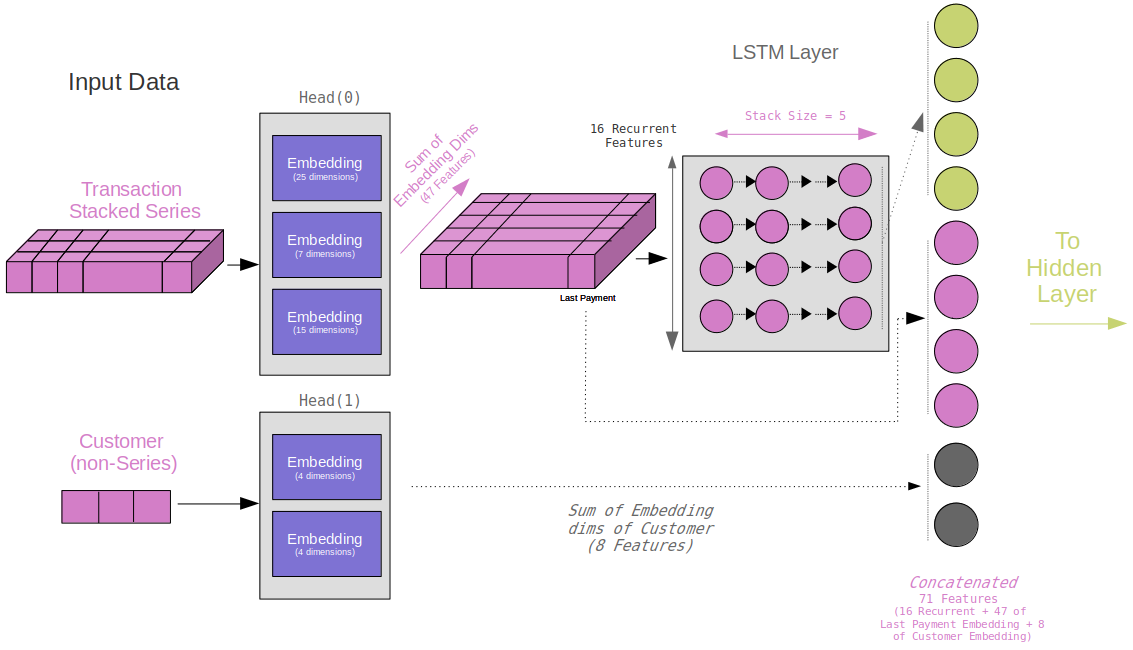

## Start Training

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. This functions iterates over the batches gradually increasing the learning rate from a minimum to a maximum learning rate.

2020-12-03 14:30:06.533 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 207.90it/s]
2020-12-03 14:30:09.092 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


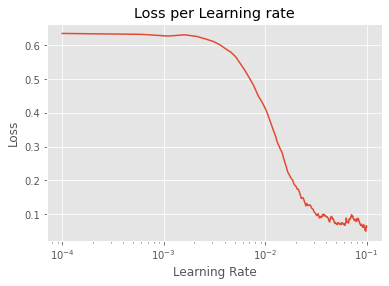

In [11]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

### Start Training and plot the results
> We train for __10 epochs__ and __learning rate 5e-3__. That means we run over the total training data set a total of 10 times/epochs where the model learns, after each epoch we use the trained model and perform a test run on the validation set. One interesting thing to note is that we get less convergence of the traning and validation curves as with the previous *Binary Recurrent* example.

Epoch 010/010: 100%|██████████| 3631/3631 [00:14<00:00, 249.13it/s, train_loss=0.0304, train_acc=0.989, val_loss=0.0211, val_acc=0.994]


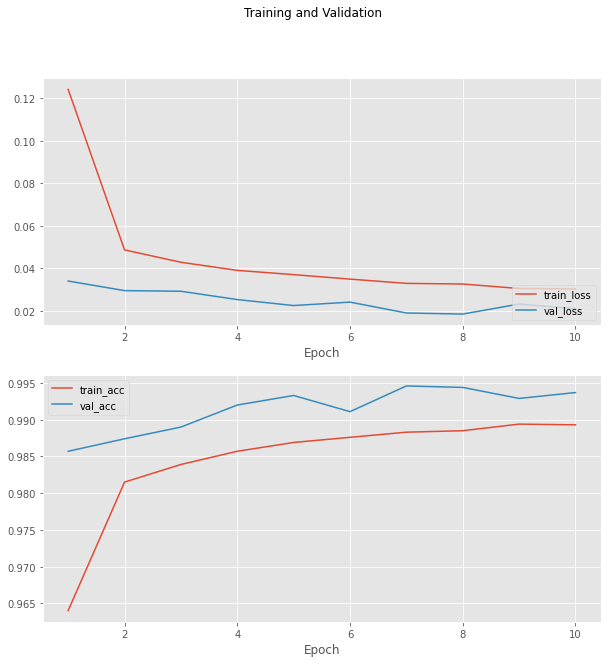

In [12]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(10, 5e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data

> Test the model on the test set, it is data that was not seen during training and allows us to validate model results. Overall this model behaves very nicely. It's not as good at keeping the FP's down as the previous recurrent example, but it does find more fraud and does not have the weird bump in the ROC curve.

Testing in 782 steps: 100%|██████████| 782/782 [00:01<00:00, 607.80it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     98926
         1.0       0.66      0.96      0.78      1074

    accuracy                           0.99    100000
   macro avg       0.83      0.98      0.89    100000
weighted avg       1.00      0.99      0.99    100000


auc score : 0.9986
ap score  : 0.9583
-----------------------------------------------------


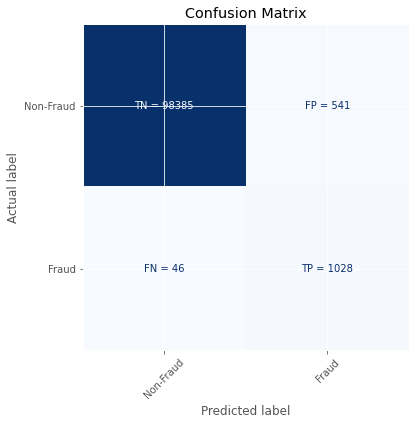

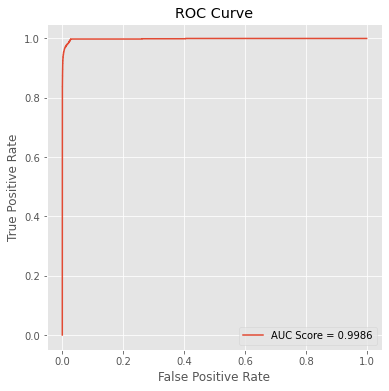

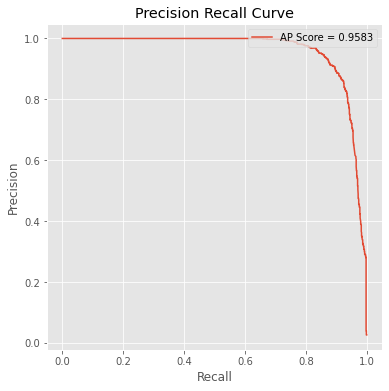

In [13]:
test_ds = pt.NumpyListDataSetMulti(multi_head_td, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()
tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))

## Plot Embeddings
> As we have embeddings in this model, we can visualize them. When compared to the embeddings from the FeedForward example, we notice a big difference in the explained variance of the first component. Some more research would need to be done, but it seems like using a sequence of categories might make the model generalize a bit better and go less aggressive after the es_leisure records.

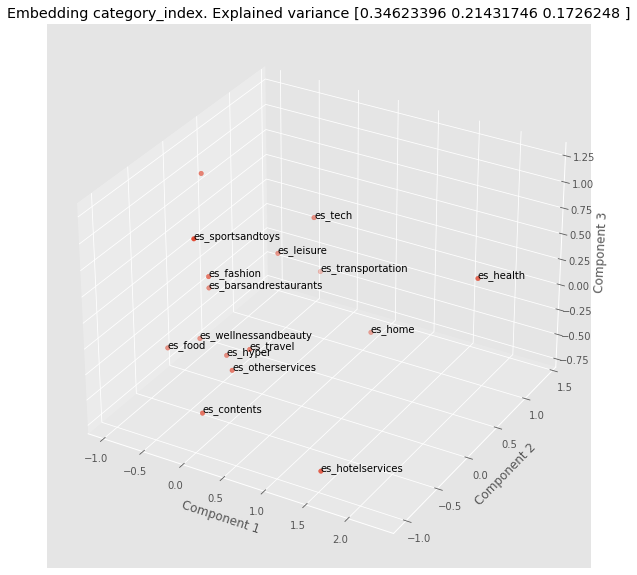

In [14]:
w = m.embedding_weights(category_i, True)
pl.LayerPlot().plot_embedding(category_i, w, dims=3, fig_size=(10,10))